# Project B: Knowledge Distillation for Building Lightweight Deep Learning Models in Visual Classification Tasks

In [1]:
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
from typing import Union

tf.enable_v2_behavior()

builder = tfds.builder('mnist')
BATCH_SIZE = 256
NUM_EPOCHS = 12
NUM_CLASSES = 10  # 10 total classes.

# Data loading

In [2]:
# Load train and test splits.
def preprocess(x):
  image = tf.image.convert_image_dtype(x['image'], tf.float32)
  subclass_labels = tf.one_hot(x['label'], builder.info.features['label'].num_classes)
  return image, subclass_labels


mnist_train, info = tfds.load('mnist', split='train', with_info=True, shuffle_files=False)
mnist_train = mnist_train.cache()
mnist_train = mnist_train.map(preprocess)
mnist_train = mnist_train.shuffle(builder.info.splits['train'].num_examples)
mnist_train = mnist_train.batch(BATCH_SIZE, drop_remainder=True)

mnist_test = tfds.load('mnist', split='test').cache()
mnist_test = mnist_test.map(preprocess).batch(BATCH_SIZE)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]


Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


# Model creation

In [ ]:
##@test {"output": "ignore"}

# Build CNN teacher.
cnn_model = tf.keras.Sequential()
# your code start from here for step 2
cnn_model.add(tf.keras.layers.Conv2D(filters=32,kernel_size=(3,3), padding="same", 
                                     activation='relu', strides=(1,1), input_shape=(28,28,1)))
cnn_model.add(tf.keras.layers.MaxPool2D(strides=1))
cnn_model.add(tf.keras.layers.Conv2D(filters=64,kernel_size=(3,3), padding="same", 
                                     activation='relu', strides=(1,1)))
cnn_model.add(tf.keras.layers.MaxPool2D(strides=2))
cnn_model.add(tf.keras.layers.Flatten())
cnn_model.add(tf.keras.layers.Dropout(rate=0.5))
cnn_model.add(tf.keras.layers.Dense(128, activation='relu'))
cnn_model.add(tf.keras.layers.Dropout(rate=0.5))
cnn_model.add(tf.keras.layers.Dense(10))
cnn_model.build()
cnn_model.summary()

# Build fully connected student.
fc_model = tf.keras.Sequential()
# your code start from here for step 2
fc_model.add(tf.keras.layers.Flatten(input_shape=(28,28,1)))
fc_model.add(tf.keras.layers.Dense(784, activation='relu'))
fc_model.add(tf.keras.layers.Dense(784, activation='relu'))
fc_model.add(tf.keras.layers.Dense(10))
fc_model.build()
fc_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 10816)             0         
                                                                 
 dropout (Dropout)           (None, 10816)             0

# Teacher loss function

In [ ]:
@tf.function
def compute_teacher_loss(images, labels):
  """Compute subclass knowledge distillation teacher loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  subclass_logits = cnn_model(images, training=True)

  # Compute cross-entropy loss for classes.
  # your code start from here for step 3
  cross_entropy_loss_value = tf.math.reduce_sum(
      tf.nn.softmax_cross_entropy_with_logits(labels, subclass_logits))

  return cross_entropy_loss_value

# Student loss function

In [ ]:
##@test {"output": "ignore"}\
def distillation_loss(teacher_logits: tf.Tensor, student_logits: tf.Tensor,
                      temperature: Union[float, tf.Tensor]):
  """Compute distillation loss.

  This function computes cross entropy between softened logits and softened
  targets. The resulting loss is scaled by the squared temperature so that
  the gradient magnitude remains approximately constant as the temperature is
  changed. For reference, see Hinton et al., 2014, "Distilling the knowledge in
  a neural network."

  Args:
    teacher_logits: A Tensor of logits provided by the teacher.
    student_logits: A Tensor of logits provided by the student, of the same
      shape as `teacher_logits`.
    temperature: Temperature to use for distillation.

  Returns:
    A scalar Tensor containing the distillation loss.
  """
 # your code start from here for step 3
  soft_targets = teacher_logits / temperature

  return tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
          soft_targets, student_logits / temperature)) * temperature ** 2

def compute_student_loss(images, labels, DISTILLATION_TEMPERATURE=64, ALPHA=0.75):
  """Compute subclass knowledge distillation student loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  student_subclass_logits = fc_model(images, training=True)

  # Compute subclass distillation loss between student subclass logits and
  # softened teacher subclass targets probabilities.

  # your code start from here for step 3
  teacher_subclass_logits = cnn_model(images, training=False)

  distillation_loss_value = ALPHA * distillation_loss(
      teacher_subclass_logits, student_subclass_logits, 
      DISTILLATION_TEMPERATURE)

  # Compute cross-entropy loss with hard targets.

  # your code start from here for step 3
  cross_entropy_loss_value = distillation_loss_value + tf.math.reduce_sum(
      tf.nn.softmax_cross_entropy_with_logits(
          labels, student_subclass_logits) * DISTILLATION_TEMPERATURE ** 2)

  return cross_entropy_loss_value

# Train and evaluation

In [ ]:
@tf.function
def compute_num_correct(model, images, labels):
  """Compute number of correctly classified images in a batch.

  Args:
    model: Instance of tf.keras.Model.
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Number of correctly classified images.
  """
  class_logits = model(images, training=False)
  return tf.reduce_sum(
      tf.cast(tf.math.equal(tf.argmax(class_logits, -1), tf.argmax(labels, -1)),
              tf.float32))

def train_and_evaluate(model, compute_loss_fn):
  """Perform training and evaluation for a given model.

  Args:
    model: Instance of tf.keras.Model.
    compute_loss_fn: A function that computes the training loss given the
      images, and labels.
  """

  # your code start from here for step 4
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

  for epoch in range(1, NUM_EPOCHS + 1):
    # Run training.
    print('Epoch {}: '.format(epoch), end='')
    for step, (images, labels) in enumerate(mnist_train):
      with tf.GradientTape() as tape:
        # your code start from here for step 4
        loss_value = compute_loss_fn(images, labels)
      grads = tape.gradient(loss_value, model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))
    # Run evaluation.
    num_correct = 0
    num_total = builder.info.splits['test'].num_examples
    for images, labels in mnist_test:
      # your code start from here for step 4
      num_correct += compute_num_correct(model, images, labels)
    print("Class_accuracy: " + '{:.2f}%'.format(
        num_correct / num_total * 100))



# Training models

In [4]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir(r'/content/drive/My Drive/Project_B_Supp/mnist_models')

Mounted at /content/drive


In [ ]:
# your code start from here for step 5 

# Train and save Teacher Model
train_and_evaluate(cnn_model, compute_teacher_loss)
cnn_model.save('teacher_model')

#Train and save Student Model
train_and_evaluate(fc_model, compute_student_loss)
fc_model.save('student_withKD_model')


Epoch 1: Class_accuracy: 96.80%
Epoch 2: Class_accuracy: 97.64%
Epoch 3: Class_accuracy: 97.79%
Epoch 4: Class_accuracy: 97.99%
Epoch 5: Class_accuracy: 97.76%
Epoch 6: Class_accuracy: 97.97%
Epoch 7: Class_accuracy: 98.23%
Epoch 8: Class_accuracy: 98.02%
Epoch 9: Class_accuracy: 97.82%
Epoch 10: Class_accuracy: 98.10%
Epoch 11: Class_accuracy: 97.72%
Epoch 12: Class_accuracy: 98.42%


INFO:tensorflow:Assets written to: student_withKD_model/assets


INFO:tensorflow:Assets written to: student_withKD_model/assets


# Test accuracy vs. temperature curve

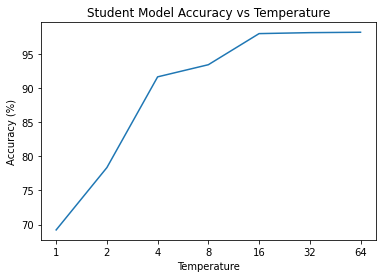

In [ ]:
# your code start from here for step 6
import matplotlib.pyplot as plt
#Values obtained through iterations of running code with different variables
student_class_accuracy = [69.22, 78.36, 91.66, 93.44, 98.00, 98.14, 98.20]
temperature = [1,2,4,8,16,32,64]

#Accuracy vs Temperature plot
plt.title('Student Model Accuracy vs Temperature')
plt.plot(student_class_accuracy)
plt.ylabel('Accuracy (%)')
plt.xticks([0,1,2,3,4,5,6], temperature)
plt.xlabel('Temperature')
plt.show()

# Train student from scratch

In [ ]:
# Build fully connected student.
fc_model_no_distillation = tf.keras.Sequential()

# your code start from here for step 7
fc_model_no_distillation.add(tf.keras.layers.Flatten(input_shape=(28,28,1)))
fc_model_no_distillation.add(tf.keras.layers.Dense(784, activation='relu'))
fc_model_no_distillation.add(tf.keras.layers.Dense(784, activation='relu'))
fc_model_no_distillation.add(tf.keras.layers.Dense(10))
fc_model_no_distillation.build()
fc_model_no_distillation.summary()

##@test {"output": "ignore"}
def compute_plain_cross_entropy_loss(images, labels):
  """Compute plain loss for given images and labels.

  For fair comparison and convenience, this function also performs a
  LogSumExp over subclasses, but does not perform subclass distillation.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  # your code start from here for step 7
  student_subclass_logits = fc_model_no_distillation(images, training=True)
  cross_entropy_loss = tf.math.reduce_sum(
      tf.nn.softmax_cross_entropy_with_logits(labels, student_subclass_logits))
  
  return cross_entropy_loss

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_7 (Flatten)         (None, 784)               0         
                                                                 
 dense_19 (Dense)            (None, 784)               615440    
                                                                 
 dense_20 (Dense)            (None, 784)               615440    
                                                                 
 dense_21 (Dense)            (None, 10)                7850      
                                                                 
Total params: 1,238,730
Trainable params: 1,238,730
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Train and evaluate student model without KD
train_and_evaluate(fc_model_no_distillation, compute_plain_cross_entropy_loss)
fc_model_no_distillation.save('student_withoutKD_model')

# Comparing the teacher and student model (number of of parameters and FLOPs) 

40/40 [==============================] - 1s 22ms/step - loss: 0.0823 - accuracy: 0.9802 - auc_30: 0.9797


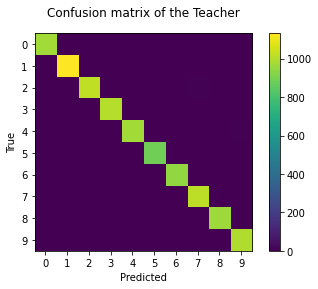

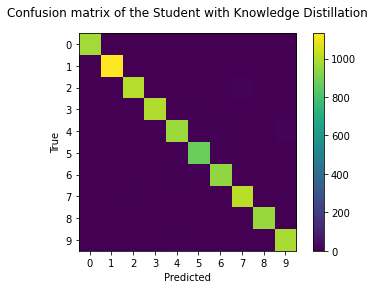

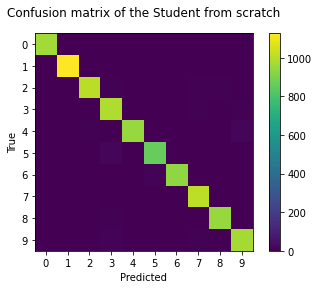

In [81]:
#load teacher
cnn_model = tf.keras.models.load_model('teacher_model',compile=False)

#load student with KD
fc_model = tf.keras.models.load_model('student_withKD_model',compile=False)

#load student without KD
fc_model_no_distillation = tf.keras.models.load_model('student_withoutKD_model',compile=False)

#Evaluate Performance
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape((-1,28,28,1)).astype('float32') / 255.0
x_test = x_test.reshape((-1,28,28,1)).astype('float32') / 255.0

cnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy', tf.keras.metrics.AUC(from_logits=True)])
cnn_model.evaluate(mnist_test)

fc_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy', tf.keras.metrics.AUC(from_logits=True)])
fc_model.evaluate(mnist_test)

fc_model_no_distillation.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy', tf.keras.metrics.AUC(from_logits=True)])
fc_model_no_distillation.evaluate(mnist_test)

teacher_pred = cnn_model.predict(x_test)
teacher_pred = np.argmax(teacher_pred, axis=1)
studentkd_pred = fc_model.predict(x_test)
studentkd_pred = np.argmax(studentkd_pred, axis=1)
studentscratch_pred = fc_model_no_distillation.predict(x_test)
studentscratch_pred = np.argmax(studentscratch_pred, axis=1)
from sklearn.metrics import confusion_matrix
#compute teacher
teacher_matrix = confusion_matrix(y_test,teacher_pred)
#plot
fig1 = plt.figure()
ax = fig1.add_subplot(111)
cax = ax.matshow(teacher_matrix)
plt.title('Confusion matrix of the Teacher')
fig1.colorbar(cax)
labels = [0,1,2,3,4,5,6,7,8,9]
ax.set_xticks(labels)
ax.set_yticks(labels)
ax.tick_params(axis="x", bottom=True, top=False, labelbottom=True, labeltop=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
#compute student with kd
studentkd_matrix = confusion_matrix(y_test, studentkd_pred)
#plot
fig2 = plt.figure()
ax = fig2.add_subplot(111)
cax = ax.matshow(studentkd_matrix)
plt.title('Confusion matrix of the Student with Knowledge Distillation')
fig2.colorbar(cax)
labels = [0,1,2,3,4,5,6,7,8,9]
ax.set_xticks(labels)
ax.set_yticks(labels)
ax.tick_params(axis="x", bottom=True, top=False, labelbottom=True, labeltop=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#computer student from scratch
studentscratch_matrix = confusion_matrix(y_test, studentscratch_pred)
#plot
fig3 = plt.figure()
ax = fig3.add_subplot(111)
cax = ax.matshow(studentscratch_matrix)
plt.title('Confusion matrix of the Student from scratch')
fig3.colorbar(cax)
labels = [0,1,2,3,4,5,6,7,8,9]
ax.set_xticks(labels)
ax.set_yticks(labels)
ax.tick_params(axis="x", bottom=True, top=False, labelbottom=True, labeltop=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
# your code start from here for step 8
#Reference: tokusumi, keras-flops, (2020), Github Repository
!pip install keras-flops
from keras_flops import get_flops

teacher_flops = get_flops(cnn_model, batch_size=1)
studentKD_flops = get_flops(fc_model, batch_size=1)
studentwithoutKD_flops = get_flops(fc_model_no_distillation, batch_size=1)
print(f"TEACHER FLOPS: {teacher_flops / 10 ** 6:.04} M")
print(f"STUDENT WITH KD FLOPS: {studentKD_flops / 10 ** 6:.04} M")
print(f"STUDENT WITHOUT KD FLOPS: {studentwithoutKD_flops / 10 ** 6:.04} M")

     |████████████████████████████████| 462 kB 8.2 MB/s 
Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`


Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`


TEACHER FLOPS: 30.31 M
STUDENT WITH KD FLOPS: 2.476 M
STUDENT WITHOUT KD FLOPS: 2.476 M


# XAI method to explain models

In [6]:
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape((-1,28,28,1)).astype('float32') / 255.0
x_test = x_test.reshape((-1,28,28,1)).astype('float32') / 255.0

11501568/11490434 [==============================] - 0s 0us/step


In [7]:
import numpy as np
def to_rgb(x):
    x_rgb = np.zeros((x.shape[0], 28, 28, 3))
    for i in range(3):
        x_rgb[..., i] = x[..., 0]
    return x_rgb
x_train = to_rgb(x_train)
x_test = to_rgb(x_test)

In [8]:
!pip install lime

import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import random

     |████████████████████████████████| 275 kB 5.3 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=618a6dbefb2c8a7b0f04ec256e86fdfe63b2b6cfec5228af888975c5307eb296
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

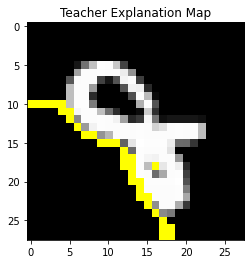

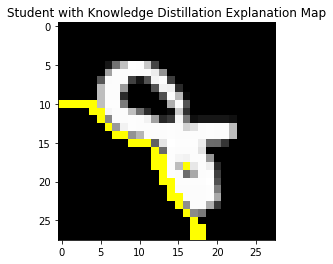

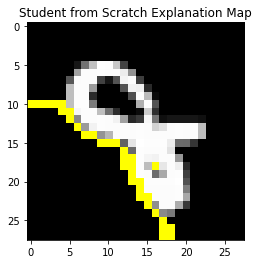

In [71]:
#Reference: marcotcr, lime, (2020), Github Repository
explainer = lime_image.LimeImageExplainer()
index = 691

def teacher_predict_fn(images):
    image = images[:,:,:,0]
    return cnn_model.predict(image)
teacher_explanation = explainer.explain_instance( 
         x_test[index],
         teacher_predict_fn,
         top_labels=1,
         num_samples=1000
)
teacher_image, teacher_mask = teacher_explanation.get_image_and_mask(
         teacher_predict_fn(
              x_test[index].reshape((1,28,28,3))
         ).argmax(axis=1)[0], 
         hide_rest=False,
         positive_only=True)
f1 = plt.figure()
plt.title("Teacher Explanation Map")
plt.imshow(x_test[index])
plt.imshow(mark_boundaries(teacher_image, teacher_mask))

def studentKD_predict_fn(images):
    image = images[:,:,:,0]
    return fc_model.predict(image)
studentKD_explanation = explainer.explain_instance( 
         x_test[index],
         studentKD_predict_fn,
         top_labels=1,
         num_samples=1000
)
studentKD_image, studentKD_mask = studentKD_explanation.get_image_and_mask(
         studentKD_predict_fn(
              x_test[index].reshape((1,28,28,3))
         ).argmax(axis=1)[0], 
         hide_rest=False,
         positive_only=True)
f2 = plt.figure()
plt.title("Student with Knowledge Distillation Explanation Map")
plt.imshow(x_test[index])
plt.imshow(mark_boundaries(studentKD_image, studentKD_mask))

def studentscratch_predict_fn(images):
    image = images[:,:,:,0]
    return fc_model_no_distillation.predict(image)
studentscratch_explanation = explainer.explain_instance( 
         x_test[index],
         studentscratch_predict_fn,
         top_labels=1,
         num_samples=1000
)
studentscratch_image, studentscratch_mask = studentKD_explanation.get_image_and_mask(
         studentscratch_predict_fn(
              x_test[index].reshape((1,28,28,3))
         ).argmax(axis=1)[0], 
         hide_rest=False,
         positive_only=True)
f3 = plt.figure()
plt.title("Student from Scratch Explanation Map")
plt.imshow(x_test[index])
plt.imshow(mark_boundaries(studentscratch_image, studentscratch_mask))


# Implementing the state-of-the-art KD algorithm

In [ ]:
# your code start from here for step 13
